In [1]:
import sys
sys.version 

'3.10.14 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:44:50) [MSC v.1916 64 bit (AMD64)]'

In [2]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [4]:
from langchain_community.chat_models.openai import ChatOpenAI
import os

gpt3 = ChatOpenAI(model_name="gpt-3.5-turbo", api_key=os.getenv("OPENAI_API_KEY"), temperature=0.7)

In [5]:
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("algorithm_education_agent")

# logging.langsmith("code_review_agent", set_enable=False)

LangSmith 추적을 시작합니다.
[프로젝트명]
algorithm_education_agent


# 함수 정의

In [6]:
from typing import Optional, Callable
from langchain.prompts import ChatPromptTemplate
from langchain.schema import StrOutputParser

# class CustomStrOutputParser(StrOutputParser):
#     def parse(self, output: str):
#         print(output)
#         return super().parse(output)

# chain 생성 함수
def create_prompt_chain(
    system_template: str, 
    human_template: str,
    model: Optional[ChatOpenAI] = None) -> Callable:
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_template), 
        ("human", human_template)
    ])
    return prompt | model | StrOutputParser()

In [7]:
from typing import TypedDict, Annotated
from langchain_core.documents import Document  # Document 객체가 정의된 모듈에서 가져와야 함

# AlgorithmState 정의
class AlgorithmState(TypedDict):
    user_input: str
    Wikipedia_search_query: str
    Wikipedia_Document: list[Document]
    Generated_answer: str

In [8]:
import re

# Step 1: 사용자 입력으로부터 검색 쿼리 생성
def create_search_query(state: AlgorithmState) -> AlgorithmState:
    query_template = """
    You are an expert in algorithms and data structures. Based on the user's input, generate a simple query to search for the key concept on Wikipedia. The input is: "{user_input}". Create the query to capture the essence of the user's question in simple keywords. 
    
    Please format your response as follows:
    Wikipedia Query: [Your query]
    """
    query_chain = create_prompt_chain(query_template, "{user_input}", gpt3)
    query = query_chain.invoke({"user_input": state["user_input"]})
    query_match = re.search(r'Wikipedia Query:\s*(.*)', query).group(1).strip() # 쿼리 추출
    
    # 상태 업데이트: Wikipedia_search_query 필드를 새 검색어로 업데이트
    state["Wikipedia_search_query"] = query_match
    
    return state

In [9]:
from langchain.document_loaders import WikipediaLoader

# Step 2: WikipediaLoader로 문서 검색
def search_wikipedia(state: AlgorithmState) -> AlgorithmState:
    # state에서 검색 쿼리 가져오기
    query = state["Wikipedia_search_query"]
    
    # WikipediaLoader를 사용해 최대 2개의 문서 로드
    loader = WikipediaLoader(query=query, load_max_docs=2)
    documents = loader.load()
    
    # 상태 업데이트: Wikipedia_Document 필드를 로드된 문서로 업데이트
    state["Wikipedia_Document"] = documents

    # 업데이트된 state 반환
    return state

In [10]:
# LaTeX 이스케이프 처리 함수 
def escape_latex(text):
    # LaTeX 수식을 찾아 이스케이프 처리 (줄바꿈 포함)
    def replace_latex(match):
        return '{{' + match.group(1) + '}}' + match.group(2)
    
    # {\\displaystyle ...}\n 패턴을 찾아 이스케이프 처리
    escaped = re.sub(r'(\{\\displaystyle [^}]+\})(\n?)', replace_latex, text)
    
    # 남은 중괄호들을 이스케이프 처리
    escaped = escaped.replace("{", "{{").replace("}", "}}")
    
    return escaped

In [11]:
# Step 3: 검색된 결과를 바탕으로 답변 생성
def generate_answer(state: AlgorithmState) -> AlgorithmState:
    qa_template = """
    Based on the Wikipedia content provided below, answer the user's question in a detailed and easy-to-understand way.
    
    Wikipedia content: {document_content}
    
    The user asked: {user_input}
    
    Provide a thorough and easy-to-follow explanation, ensuring the response is detailed and simplified for clear understanding using the Wikipedia data. 
    Additionally, use examples to make the explanation clearer and more relatable.
    """
    
    # create_prompt_chain이 이미 정의되어 있다고 가정
    qa_chain = create_prompt_chain(qa_template, "{user_input}\n{document_content}", gpt3)
    
    # state에서 Wikipedia_Document 가져오기
    documents = state["Wikipedia_Document"]
    
    # 문서의 내용을 모두 합쳐 하나의 문자열로 만들기
    document_content = " ".join([escape_latex(doc.page_content) for doc in documents])
    
    # 질문과 문서 내용을 바탕으로 답변 생성
    answer = qa_chain.invoke({"user_input": state["user_input"], "document_content": document_content})
    
    # 상태 업데이트: Generated_answer 필드에 생성된 답변 저장
    state["Generated_answer"] = answer

    # 업데이트된 state 반환
    return state

# Algorithm Education Graph

In [12]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 알고리즘 및 자료구조 교육 워크플로우 생성
Algorithm_workflow = StateGraph(AlgorithmState)

In [13]:
from langgraph.graph import START, END, StateGraph

# 각 단계의 노드 추가
Algorithm_workflow.add_node("create_search_query", create_search_query)
Algorithm_workflow.add_node("search_wikipedia", search_wikipedia)
Algorithm_workflow.add_node("generate_answer", generate_answer)

# 노드 간의 연결 설정 (단계별 흐름)
Algorithm_workflow.add_edge("create_search_query", "search_wikipedia")
Algorithm_workflow.add_edge("search_wikipedia", "generate_answer")
Algorithm_workflow.add_edge("generate_answer", END)

Algorithm_workflow.set_entry_point("create_search_query")

In [14]:
# 워크플로우 컴파일 및 그래프 시각화
Algorithm_app = Algorithm_workflow.compile()

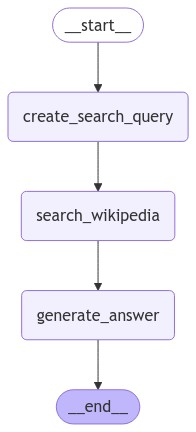

In [15]:
from IPython.display import Image, display

try:
    display(
        Image(Algorithm_app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

# 결과물

In [16]:
test_input = "I don't really understand what the Selection Sort algorithm is. Please explain it to me in detail and in an easy way."

In [21]:
answer = Algorithm_app.invoke(AlgorithmState(user_input=test_input))

In [22]:
from IPython.display import display, Markdown
display(Markdown(answer["Generated_answer"]))

Selection Sort is a simple sorting algorithm used in computer science. It is an in-place comparison sorting algorithm, meaning it sorts elements by comparing them and swapping their positions within the original array. Selection sort has a time complexity of O(n^2), which means its efficiency decreases as the number of elements in the array increases. However, it can be advantageous in situations where memory is limited.

Here is a breakdown of how the Selection Sort algorithm works:
1. The algorithm divides the input list into two parts: a sorted sublist and an unsorted sublist.
2. Initially, the sorted sublist is empty, and the unsorted sublist contains all the elements.
3. The algorithm repeatedly finds the smallest (or largest, depending on the sorting order) element in the unsorted sublist.
4. It then swaps this element with the leftmost unsorted element, placing it in the sorted order.
5. The boundaries of the sorted and unsorted sublists are adjusted by moving one element to the right.
6. This process is repeated until all elements are sorted.

For example, let's sort an array [64, 25, 12, 22, 11] using Selection Sort:
- Find the minimum element in the array and place it at the beginning: [11, 25, 12, 22, 64]
- Find the next minimum element in the remaining array and place it in the second position: [11, 12, 25, 22, 64]
- Repeat this process until all elements are in sorted order: [11, 12, 22, 25, 64]

Selection sort is not the most efficient sorting algorithm, especially for large arrays, due to its quadratic time complexity. There are other sorting techniques with better time complexity, like merge sort or quicksort. However, selection sort is easy to implement, requires minimal auxiliary memory, and can be useful in specific scenarios.

In summary, Selection Sort is a straightforward algorithm that repeatedly selects the smallest element from the unsorted part of the array and places it in the correct position in the sorted part, making it a good option for small datasets or situations where simplicity is preferred over speed.